In [98]:
%load_ext autoreload
%autoreload 2

In [99]:
from bitcoin_deep_learning.call_api import ApiCall
from bitcoin_deep_learning.metrics import *
from bitcoin_deep_learning.model import LinearRegressionBaselineModel
from bitcoin_deep_learning.cross_val import cross_val_trade
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [100]:
! pwd

/Users/alexandrelaizet/code/AlexandreLaizet/bitcoin_deep_learning/notebooks


In [101]:
df = ApiCall().read_local(data="train")

In [102]:
[df.columns][0]

Index(['date', '[AVG]_[NH]_mean_hash_rate', '[+]_[NH]_Days_Till_Halving',
       '[//]_[AV]_Stock-to-Flow_Ratio', '[+]_[NH]_Circulating_Supply',
       '[+]_[NH]_Issuance', '[+]_[NH]_Number_of_Active_Addresses',
       '[+]_[NH]_Mean_Block_Interval', '[+]_[NH]_Number_of_Transactions',
       '[+]_[NH]_Number_of_Addresses_with_a_Non-Zero_Balance',
       '[+]_[NH]_Number_of_Addresses_with_Balance_≥_10k',
       '[%]_[BSB]_Percent_of_Supply_Last_Active_1+_Years_Ago',
       '[//]_[BSB]_Realized_HODL_Ratio',
       '[AVG]_[BSB]_Average_Spent_Output_Lifespan_(ASOL)',
       '[//]_[BSB]_Liveliness',
       '[%]_[BSB]_Percent_Balance_on_Exchanges_-_All_Exchanges',
       '[$]_[BSB]_Exchange_Net_Position_Change_-_All_Exchanges',
       '[//]_[BSB]_Realized_Profit/Loss_Ratio',
       '[$]_[BSB]_Net_Unrealized_Profit/Loss_(NUPL)',
       '[$]_[BSB]_Realized_Price', '[%]_[BSB]_Price_Drawdown_from_ATH',
       '[//]_[AV]_Market_Value_to_Realized_Value_Ratio_(MVRV)',
       '[//]_[AV]_Puell_Multip

In [103]:
from sklearn.preprocessing import MinMaxScaler
data = df.copy().drop(columns=["date"])
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data), columns=scaler.get_feature_names_out())


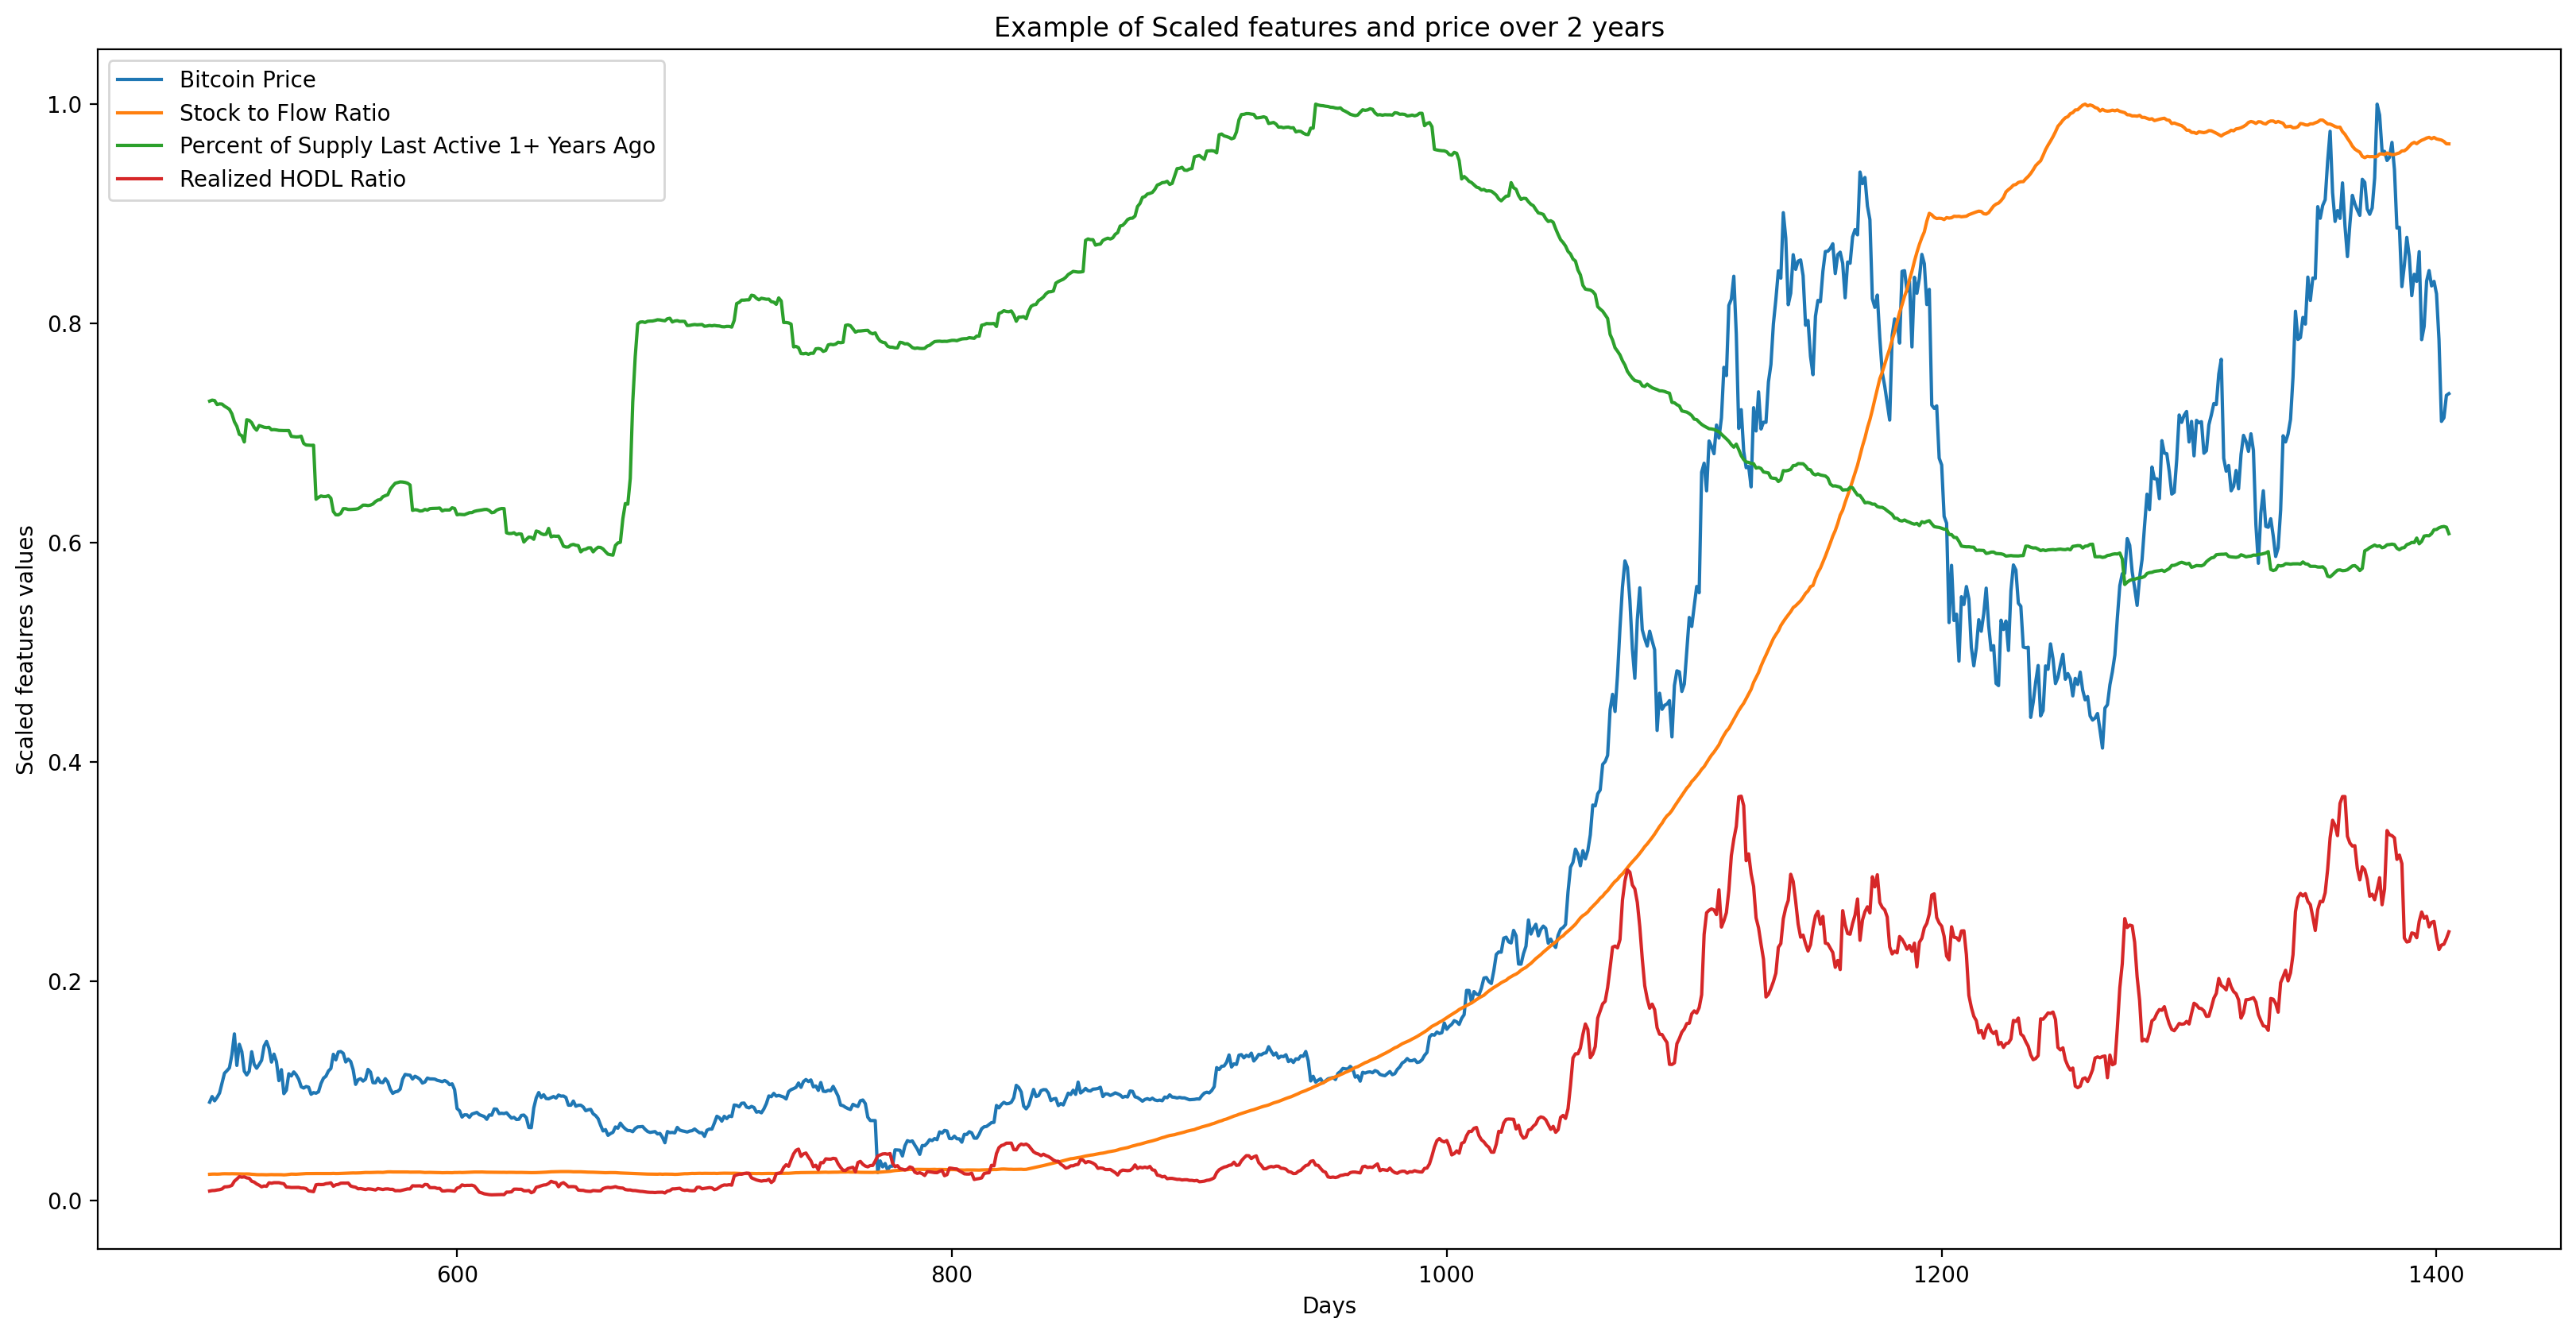

In [104]:
figure(figsize=(20, 10), dpi=200)

plt.plot(data_scaled["[+]_[T]_Bitcoin_Price"][500:], label="Bitcoin Price")
plt.plot(data_scaled["[//]_[AV]_Stock-to-Flow_Ratio"][500:], label="Stock to Flow Ratio")
plt.plot(data_scaled["[%]_[BSB]_Percent_of_Supply_Last_Active_1+_Years_Ago"][500:], label="Percent of Supply Last Active 1+ Years Ago")
plt.plot(data_scaled["[//]_[BSB]_Realized_HODL_Ratio"][500:], label="Realized HODL Ratio")


plt.title("Example of Scaled features and price over 2 years")
plt.xlabel("Days")
plt.ylabel("Scaled features values")
plt.legend();

In [105]:
model = LinearRegressionBaselineModel(alpha = 0.05 , l1_ratio = 0.0001)
roi_hodler, roi_trader, roi_whale, roi_hodler_whale, roi_charles, sharpe_hodler, sharpe_trader, sharpe_whale, sharpe_hodler_whale, sharpe_charles = iterate_cross_val_results(model = model)
print("---")
print("Hodler roi: ", roi_hodler)
print("Hodler sharpe ratio: ", sharpe_hodler)
print("---")
print("Trader roi: ", roi_trader)
print("Trader sharpe ratio: ", sharpe_trader)
print("---")
print("Whale roi: ", roi_whale)
print("Whale sharpe ratio: ", sharpe_whale)
print("---")
print("Hodler whale roi: ", roi_hodler_whale)
print("Hodler whale sharpe ratio: ", sharpe_hodler_whale)
print("---")
print("Charles roi: ", roi_charles)
print("Charles sharpe ratio: ", sharpe_charles)

[0.27702074865321724, 0.39866031865659446, 0.48796419106135147, 0.33443788814979536, 0.14175623511513047, -0.2824240613868797, -0.29076824191104333, -0.24699767200798428, -0.12283953354687571, -0.060139076467191965, 0.16689361278589554, -0.20495794683518231, -0.2654374044503006, 0.025969350391875423, 0.30519269559589635, 0.1080712096662022, 0.0, 0.12772166178061983, 0.023539343735346607, 0.283302223859873, 0.3643598609667289, 0.3628971097223732, 0.3651169244895911, 0.37344415648179985, 0.38341082597163556, -0.14638556686848347, -0.24133489844179024, -0.38243218377026755, 0.20217003805619904, 0.2192444658295618, 0.32234273596290053, 0.18448470378028614]
---
Hodler roi:  0.07606282088812734
Hodler sharpe ratio:  2.692378821921656
---
Trader roi:  -0.012438564785148456
Trader sharpe ratio:  -0.7122943147130746
---
Whale roi:  -0.01882928103769756
Whale sharpe ratio:  -0.52968939603384
---
Hodler whale roi:  -0.01882928103769756
Hodler whale sharpe ratio:  -0.52968939603384
---
Charles roi

In [106]:
def iterate_portfolio_positions(model = LinearRegressionBaselineModel(alpha = 0.05 , l1_ratio = 0.0001), df = df):

    portfolio_positions_hodler = []
    portfolio_positions_trader = []
    portfolio_positions_whale = []
    portfolio_positions_hodler_whale = []
    portfolio_positions_charles = []

    past_realities, realities, realities_diff, prediction_diff = cross_val_trade(model, df)
    ct = 0
    preds = []
    preds_arr = []
    
    for past_prices, diffs in zip(past_realities,prediction_diff):
        for diff in diffs:
            preds.append(past_prices[ct] + past_prices[ct] * diff)
            ct += 1
        preds_arr.append(np.array(preds))
        preds.clear()
        ct = 0

    for reality, prediction in zip(realities, preds_arr):
        y_true, y_pred = reality, prediction
        
        portfolio_positions_hodler.append(play_hodler_strategy(y_true, y_pred))
        portfolio_positions_trader.append(play_trader_strategy(y_true, y_pred))
        portfolio_positions_whale.append(play_whale_strategy(y_true, y_pred))
        portfolio_positions_hodler_whale.append(play_hodler_whale_strategy(y_true, y_pred))
        portfolio_positions_charles.append(play_charles_strategy(y_true, y_pred))

    return portfolio_positions_hodler, portfolio_positions_trader, portfolio_positions_whale, portfolio_positions_hodler_whale, portfolio_positions_charles



In [108]:
hodler, trader, whale, hodler_whale, charles = iterate_portfolio_positions()

In [149]:
def plot_portolio_positions(positions=iterate_portfolio_positions(model = LinearRegressionBaselineModel(alpha = 0.05 , l1_ratio = 0.0001), df = df)): 
    
    hodler, trader, whale, hodler_whale, charles = positions
    
    figure(figsize=(20, 10), dpi=200)

    #4
    plt.plot(hodler[4][:-1], label="Hodler")
    plt.plot(trader[4][:-1], label="Trader")
    plt.plot(whale[4][:-1], label="Whale")
    plt.plot(hodler_whale[4][:-1], label="Hodler whale")
    plt.plot(charles[4][:-1], label="Charles")

    plt.title("Example of portfolio evolution over 3 months by investment strategy")
    plt.xlabel("Days")
    plt.ylabel("USD + BTC-USD portfolio value")
    plt.legend();

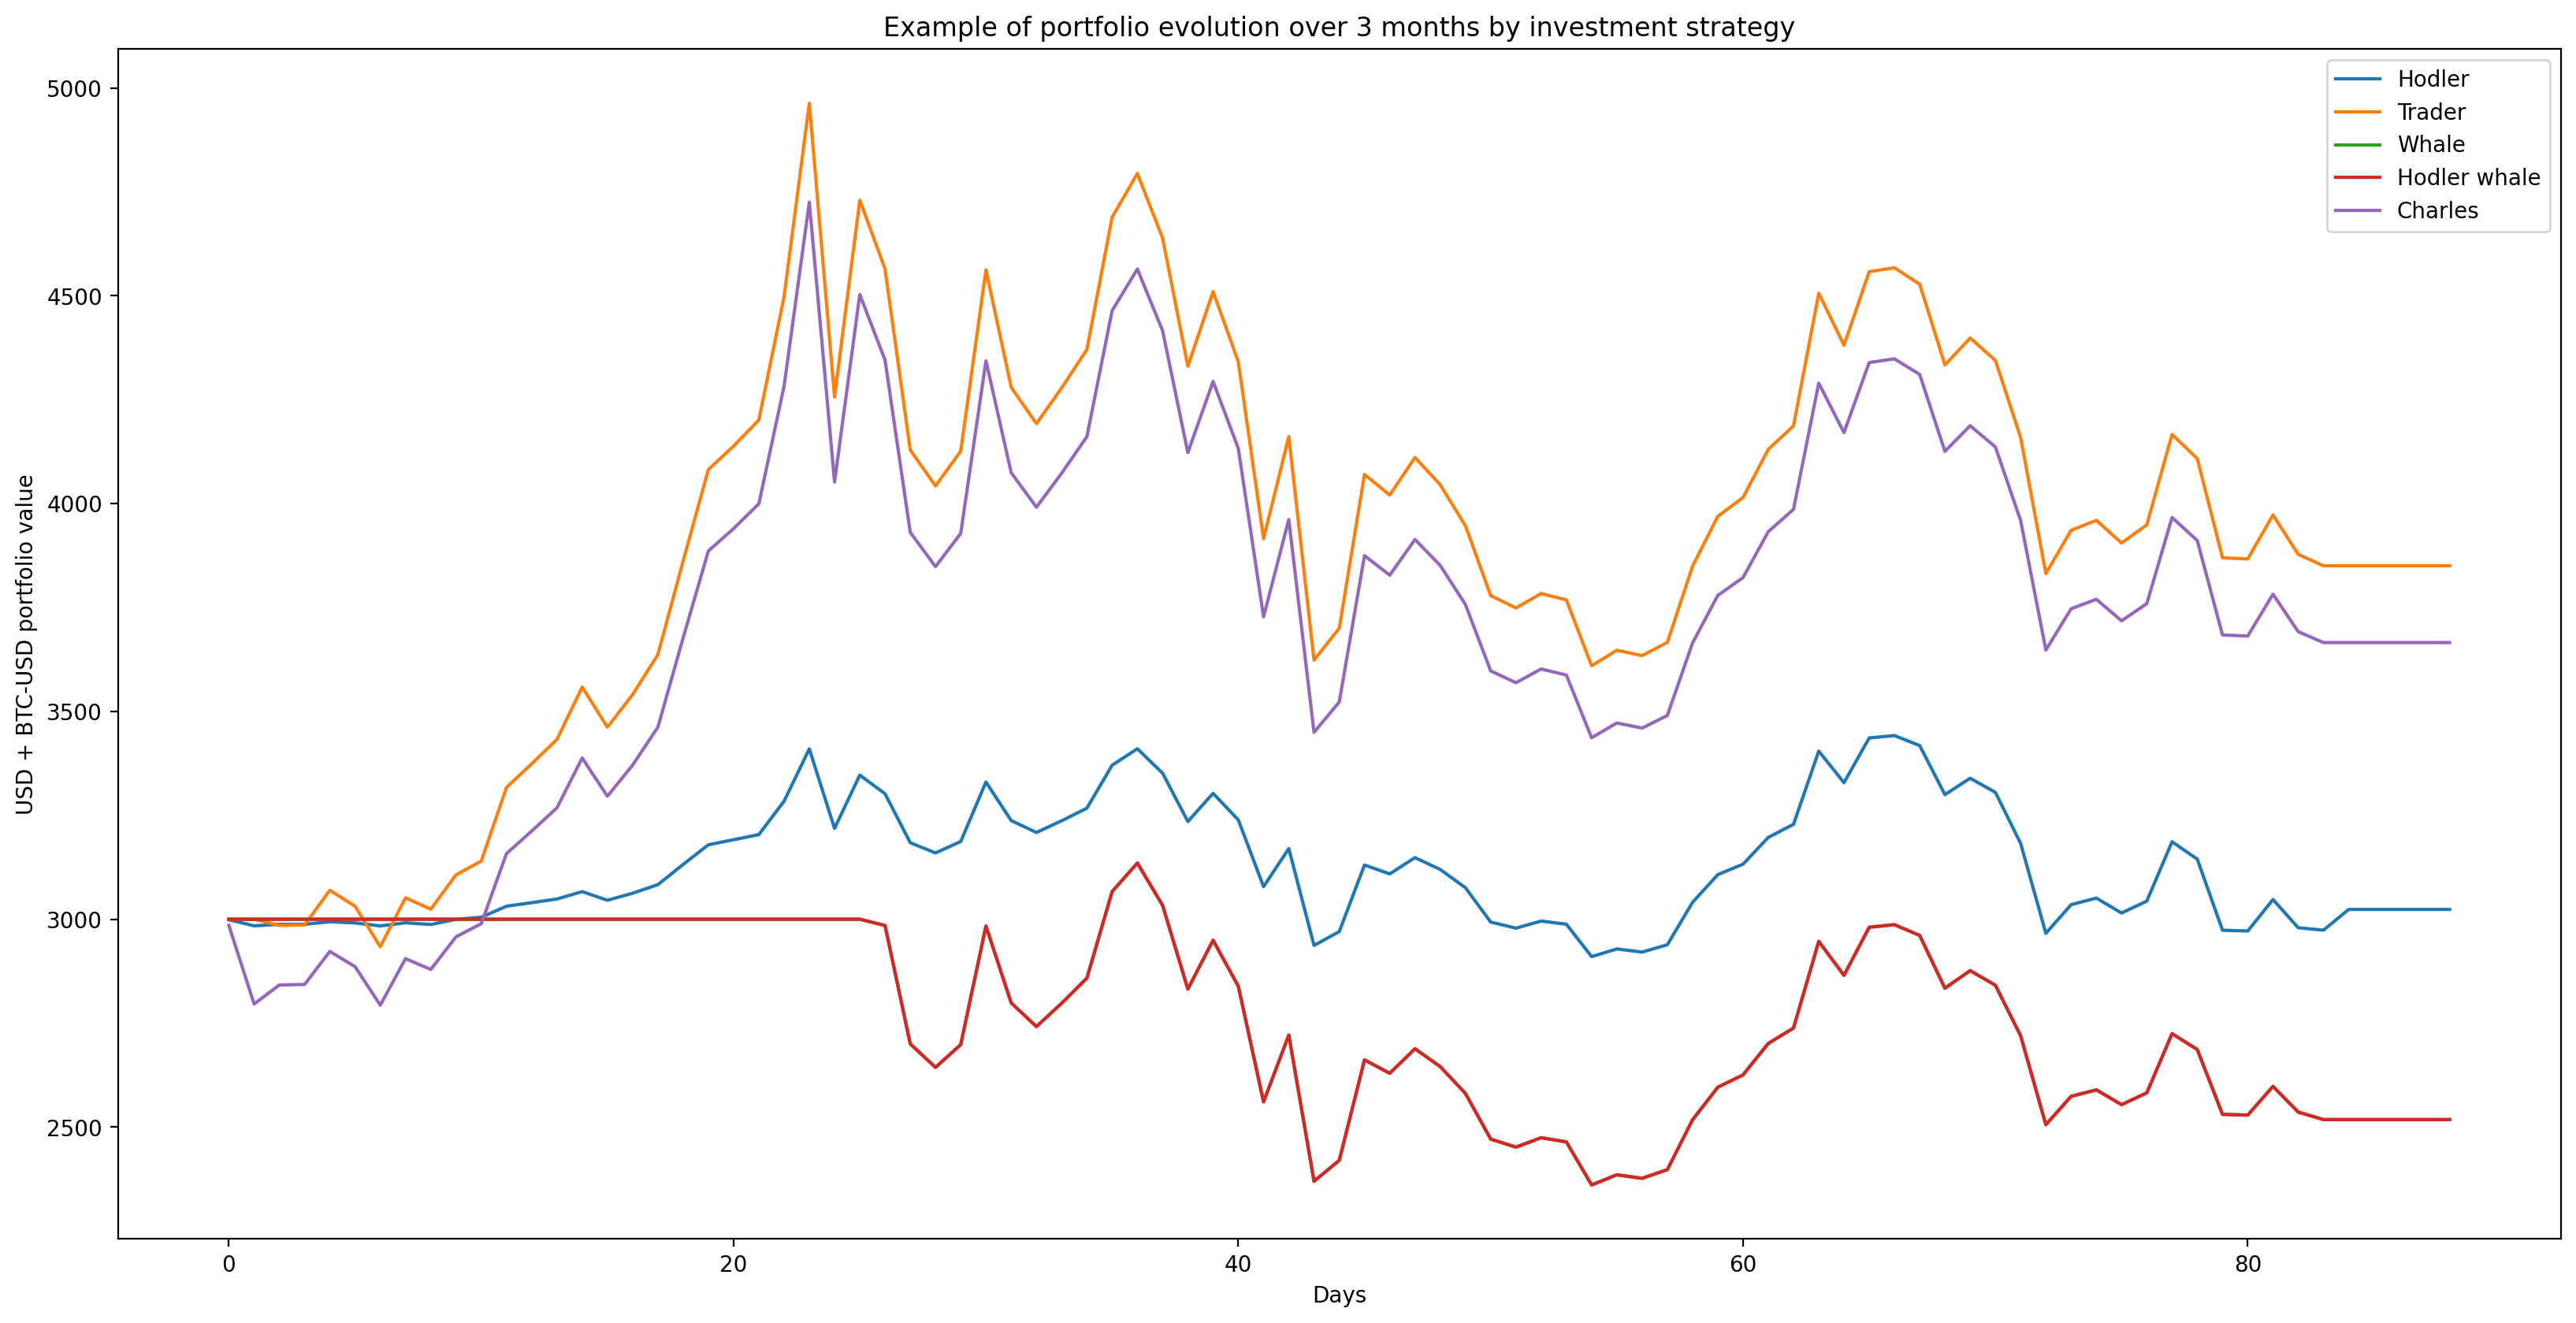

In [150]:
plot_portolio_positions(positions=iterate_portfolio_positions(model = LinearRegressionBaselineModel(alpha = 0.05 , l1_ratio = 0.0001), df = df))